In [2]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2025-11-03 17:50:24.989300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762192225.248936      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762192225.321283      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version: 2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import math, json, requests, datetime as dt
import numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Repro
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# Location: Bengaluru
LAT, LON = 12.9716, 77.5946
TZ = "Asia/Kolkata"

# Targets we’ll predict (you can add more later)
CONT_TARGETS = ["temperature_2m", "relative_humidity_2m", "surface_pressure", "wind_speed_10m", "precipitation"]
BIN_TARGETS   = ["precip_yes"]  # derived from precipitation > 0
ALL_TARGETS   = CONT_TARGETS + BIN_TARGETS

# Horizon & context
HORIZON_H = 72     # predict next 72 hourly steps
LOOKBACK_H = 72    # use past 72 hours as input features

# Historical training window (adjust as you like)
TRAIN_START = "2023-01-01"
TRAIN_END   = (dt.datetime.now(dt.timezone.utc) - dt.timedelta(days=3)).date().isoformat()


In [4]:
# === Data Pull: Open-Meteo Historical ===
BASE = "https://archive-api.open-meteo.com/v1/era5"
VARS = [
    "temperature_2m",
    "relative_humidity_2m",
    "surface_pressure",
    "wind_speed_10m",
    "precipitation",     # mm
]
def fetch_hourly_history(lat, lon, start_date, end_date, tz=TZ):
    params = {
        "latitude": lat, "longitude": lon,
        "start_date": start_date, "end_date": end_date,
        "hourly": ",".join(VARS),
        "timezone": tz,
    }
    r = requests.get(BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    # to DataFrame
    df = pd.DataFrame(data["hourly"])
    df.rename(columns={"time": "datetime"}, inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    return df

raw = fetch_hourly_history(LAT, LON, TRAIN_START, TRAIN_END)
raw.head()


,datetime,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,precipitation
0,2023-01-01 00:00:00,16.3,74,915.7,9.4,0.0
1,2023-01-01 01:00:00,16.1,75,915.0,9.8,0.0
2,2023-01-01 02:00:00,15.7,80,914.2,9.8,0.0
3,2023-01-01 03:00:00,15.3,84,913.8,10.2,0.0
4,2023-01-01 04:00:00,14.9,89,913.8,9.1,0.0


In [5]:
# === Preprocess ===
df = raw.copy()
df = df.sort_values("datetime").drop_duplicates("datetime")
df = df.set_index("datetime").asfreq("h")  # strict hourly grid

# Interpolate small gaps in continuous vars
for c in CONT_TARGETS:
    df[c] = df[c].interpolate(limit=3).bfill().ffill()

# Binary precipitation (yes/no)
df["precip_yes"] = (df["precipitation"] > 0.0).astype(int)

# Cyclical time features
df["hour"] = df.index.hour
df["dow"] = df.index.dayofweek
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)

# Optional: rolling stats to help the model (comment in if needed)
ROLL_BASES = ["temperature_2m", "relative_humidity_2m", "surface_pressure", "wind_speed_10m", "precipitation"]
for col in ROLL_BASES:
    df[f"{col}_rmean_6"]  = df[col].rolling(6, min_periods=1).mean()
    df[f"{col}_rstd_6"]   = df[col].rolling(6, min_periods=1).std().fillna(0)
    df[f"{col}_rmean_24"] = df[col].rolling(24, min_periods=1).mean()
    df[f"{col}_rstd_24"]  = df[col].rolling(24, min_periods=1).std().fillna(0)

# Feature columns (everything except future labels)
FEATS = [c for c in df.columns if c not in ALL_TARGETS] + CONT_TARGETS  # include contemporaneous weather as inputs
FEATS = list(dict.fromkeys(FEATS))  # keep order, dedup
df


,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,precipitation,precip_yes,hour,dow,hour_sin,hour_cos,...,surface_pressure_rmean_24,surface_pressure_rstd_24,wind_speed_10m_rmean_6,wind_speed_10m_rstd_6,wind_speed_10m_rmean_24,wind_speed_10m_rstd_24,precipitation_rmean_6,precipitation_rstd_6,precipitation_rmean_24,precipitation_rstd_24
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,16.3,74,915.7,9.4,0.0,0,0,6,0.000000,1.000000,...,915.700000,0.000000,9.400000,0.000000,9.400000,0.000000,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,16.1,75,915.0,9.8,0.0,0,1,6,0.258819,0.965926,...,915.350000,0.494975,9.600000,0.282843,9.600000,0.282843,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,15.7,80,914.2,9.8,0.0,0,2,6,0.500000,0.866025,...,914.966667,0.750555,9.666667,0.230940,9.666667,0.230940,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,15.3,84,913.8,10.2,0.0,0,3,6,0.707107,0.707107,...,914.675000,0.846069,9.800000,0.326599,9.800000,0.326599,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,14.9,89,913.8,9.1,0.0,0,4,6,0.866025,0.500000,...,914.500000,0.830662,9.660000,0.421900,9.660000,0.421900,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,22.5,68,913.0,5.1,0.0,0,19,4,-0.965926,0.258819,...,913.345833,1.227928,9.433333,4.016798,9.466667,2.773738,0.0,0.0,0.0,0.0
2025-10-31 20:00:00,22.3,67,913.8,5.6,0.0,0,20,4,-0.866025,0.500000,...,913.370833,1.230934,8.050000,3.575891,9.454167,2.791132,0.0,0.0,0.0,0.0
2025-10-31 21:00:00,21.6,70,913.9,5.1,0.0,0,21,4,-0.707107,0.707107,...,913.387500,1.235459,6.783333,2.877093,9.420833,2.839776,0.0,0.0,0.0,0.0


In [6]:
# === Windowing ===
def make_windows(frame, feat_cols, targets_cont, targets_bin, lookback=72, horizon=72):
    X_list, Yc_list, Yb_list, t0_list = [], [], [], []
    values_feats = frame[feat_cols].values.astype(np.float32)
    values_cont  = frame[targets_cont].values.astype(np.float32)
    values_bin   = frame[targets_bin].values.astype(np.float32)

    for i in range(lookback, len(frame)-horizon):
        X = values_feats[i-lookback:i, :]
        Yc = values_cont[i:i+horizon, :]  # (H, n_cont)
        Yb = values_bin[i:i+horizon, :]   # (H, n_bin)
        X_list.append(X); Yc_list.append(Yc); Yb_list.append(Yb); t0_list.append(frame.index[i-1])

    X = np.stack(X_list)
    Yc = np.stack(Yc_list)
    Yb = np.stack(Yb_list)
    t0 = np.array(t0_list)
    return X, Yc, Yb, t0

# Split: last N days for validation (e.g., last 60 days)
VAL_DAYS = 60
split_time = df.index.max() - pd.Timedelta(days=VAL_DAYS)
train_df = df[df.index <= split_time].copy()
val_df   = df[df.index >  split_time].copy()

X_train, Yc_train, Yb_train, t0_train = make_windows(train_df, FEATS, CONT_TARGETS, BIN_TARGETS, LOOKBACK_H, HORIZON_H)
X_val,   Yc_val,   Yb_val,   t0_val   = make_windows(val_df,   FEATS, CONT_TARGETS, BIN_TARGETS, LOOKBACK_H, HORIZON_H)

X_train.shape, Yc_train.shape, Yb_train.shape

((23256, 72, 31), (23256, 72, 5), (23256, 72, 1))

In [7]:
def build_model(n_feat, n_cont, n_bin, lookback, horizon, units=128, dropout=0.2):
    inp = keras.Input(shape=(lookback, n_feat))

    # Encoder
    x = layers.Masking()(inp)
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(dropout)(x)

    # Decoder
    x = layers.RepeatVector(horizon)(x)
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(128, activation="relu"))(x)

    # Outputs
    cont_out = layers.TimeDistributed(layers.Dense(n_cont, activation="linear"), name="cont")(x)
    bin_out  = layers.TimeDistributed(layers.Dense(n_bin, activation="sigmoid"), name="bin")(x)

    model = keras.Model(inp, [cont_out, bin_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={"cont": "mse", "bin": "binary_crossentropy"},
        loss_weights={"cont": 1.0, "bin": 1.0},
        metrics={
            "cont": [keras.metrics.MeanAbsoluteError(name="MAE")],
            "bin": [
                keras.metrics.AUC(name="AUC"),
                keras.metrics.Precision(name="Precision"),
                keras.metrics.Recall(name="Recall")
            ],
        },
    )

    return model

In [8]:
# === Scaling ===
feat_scaler = StandardScaler()
cont_scaler = StandardScaler()

# fit on train only
n_feat = X_train.shape[-1]
X_train_2d = X_train.reshape(-1, n_feat)
X_val_2d   = X_val.reshape(-1, n_feat)

feat_scaler.fit(X_train_2d)
X_train_s = feat_scaler.transform(X_train_2d).reshape(X_train.shape)
X_val_s   = feat_scaler.transform(X_val_2d).reshape(X_val.shape)

n_cont = Yc_train.shape[-1]
Yc_train_2d = Yc_train.reshape(-1, n_cont)
Yc_val_2d   = Yc_val.reshape(-1, n_cont)

cont_scaler.fit(Yc_train_2d)
Yc_train_s = cont_scaler.transform(Yc_train_2d).reshape(Yc_train.shape)
Yc_val_s   = cont_scaler.transform(Yc_val_2d).reshape(Yc_val.shape)

# Binary targets untouched
Yb_train_s = Yb_train.copy()
Yb_val_s   = Yb_val.copy()

In [9]:
model = build_model(
    n_feat=X_train.shape[-1],
    n_cont=n_cont,
    n_bin=Yb_train.shape[-1],
    lookback=LOOKBACK_H,
    horizon=HORIZON_H,
    units=128,
    dropout=0.2
)

model.summary()

I0000 00:00:1762192245.544867      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 72, 31)    │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 72, 31)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 72)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 72, 256)   │    163,840 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    394,240 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 72, 256)   │          0 │ dropout[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 72, 256)   │    394,240 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 72, 128)   │     32,896 │ bidirectional_2[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cont                │ (None, 72, 5)     │        645 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin                 │ (None, 72, 1)     │        129 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 985,990 (3.76 MB)

 Trainable params: 985,990 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]

hist = model.fit(
    X_train_s, {"cont": Yc_train_s, "bin": Yb_train_s},
    validation_data=(X_val_s, {"cont": Yc_val_s, "bin": Yb_val_s}),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1762192268.308205      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


364/364 ━━━━━━━━━━━━━━━━━━━━ 49s 71ms/step - bin_AUC: 0.7984 - bin_Precision: 0.5025 - bin_Recall: 0.1638 - bin_loss: 0.3821 - cont_MAE: 0.5668 - cont_loss: 0.6720 - loss: 1.0541 - val_bin_AUC: 0.6237 - val_bin_Precision: 0.4798 - val_bin_Recall: 0.4660 - val_bin_loss: 0.6962 - val_cont_MAE: 0.4332 - val_cont_loss: 0.6585 - val_loss: 1.3657 - learning_rate: 0.0010
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - bin_AUC: 0.9041 - bin_Precision: 0.6645 - bin_Recall: 0.5104 - bin_loss: 0.2865 - cont_MAE: 0.3128 - cont_loss: 0.3159 - loss: 0.6024 - val_bin_AUC: 0.6418 - val_bin_Precision: 0.4929 - val_bin_Recall: 0.4413 - val_bin_loss: 0.7020 - val_cont_MAE: 0.4298 - val_cont_loss: 0.6785 - val_loss: 1.3851 - learning_rate: 0.0010
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - bin_AUC: 0.9243 - bin_Precision: 0.7014 - bin_Recall: 0.5775 - bin_loss: 0.2582 - cont_MAE: 0.2831 - cont_loss: 0.2753 - loss: 0.5335 - val_bin_AUC: 0.6500 - val_bin_Precision: 0.4960 - val_bin_Recal

In [11]:
pred_cont_s, pred_bin = model.predict(X_val_s, verbose=0)

# unscale continuous predictions
pred_cont_2d = pred_cont_s.reshape(-1, n_cont)
true_cont_2d = Yc_val_s.reshape(-1, n_cont)
pred_cont = cont_scaler.inverse_transform(pred_cont_2d).reshape(pred_cont_s.shape)
true_cont = cont_scaler.inverse_transform(true_cont_2d).reshape(Yc_val_s.shape)

true_bin = Yb_val
pred_prob = pred_bin

from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, f1_score
import numpy as np, math

def rmse(a, b): return math.sqrt(mean_squared_error(a, b))

print("== Continuous targets ==")
for j, name in enumerate(CONT_TARGETS):
    mae = mean_absolute_error(true_cont[..., j].ravel(), pred_cont[..., j].ravel())
    r = rmse(true_cont[..., j].ravel(), pred_cont[..., j].ravel())
    print(f"{name:22s}  MAE={mae:.3f}  RMSE={r:.3f}")

print("\n== Precipitation yes/no ==")
y_true = true_bin[..., 0].ravel()
y_score = pred_prob[..., 0].ravel()
y_pred = (y_score >= 0.5).astype(int)
print(f"AUC={roc_auc_score(y_true, y_score):.3f}  F1={f1_score(y_true, y_pred):.3f}")

== Continuous targets ==
temperature_2m          MAE=1.086  RMSE=1.405
relative_humidity_2m    MAE=6.659  RMSE=8.627
surface_pressure        MAE=1.018  RMSE=1.299
wind_speed_10m          MAE=2.995  RMSE=3.811
precipitation           MAE=0.369  RMSE=0.830

== Precipitation yes/no ==
AUC=0.624  F1=0.473


/tmp/ipykernel_37/1618501702.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  horizon_times = pd.date_range(base_time + pd.Timedelta(hours=1), periods=HORIZON_H, freq="H")
/tmp/ipykernel_37/1618501702.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  horizon_times = pd.date_range(base_time, periods=HORIZON_H, freq="H")


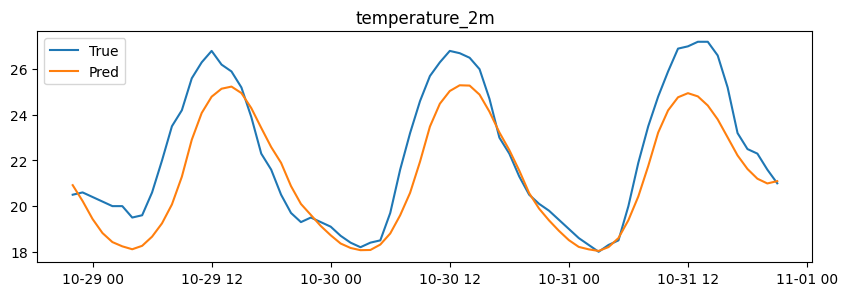

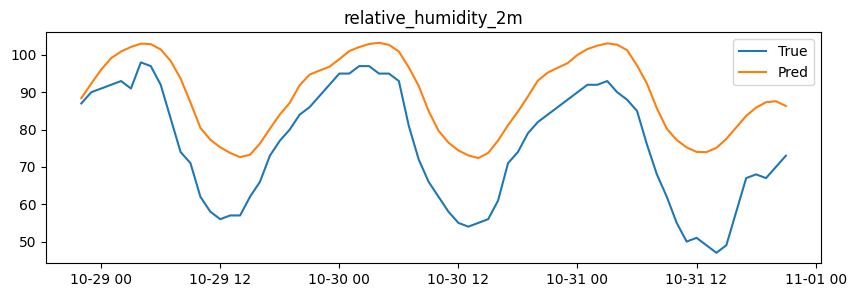

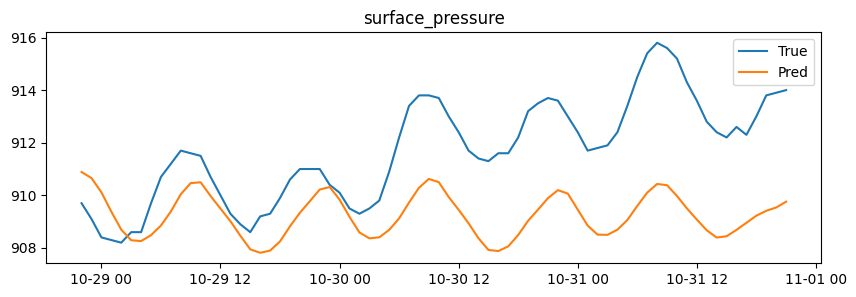

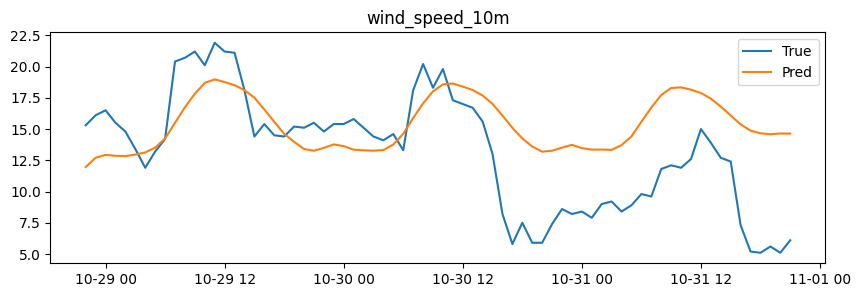

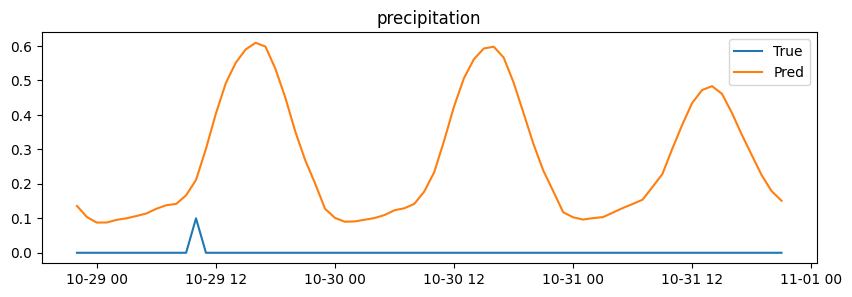

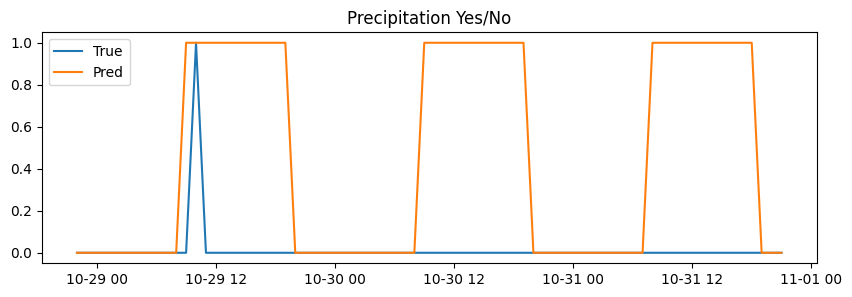

In [12]:
def plot_sample(idx=-1):
    import matplotlib.pyplot as plt
    t0 = t0_val[idx]
    # Find the first timestamp >= t0, then move forward 1 step to start forecast window
    pos = val_df.index.searchsorted(t0)
    base_time = val_df.index[pos] if pos < len(val_df.index) else val_df.index[-1]
    horizon_times = pd.date_range(base_time + pd.Timedelta(hours=1), periods=HORIZON_H, freq="H")

    horizon_times = pd.date_range(base_time, periods=HORIZON_H, freq="H")

    for j, name in enumerate(CONT_TARGETS):
        plt.figure(figsize=(10,3))
        plt.plot(horizon_times, true_cont[idx, :, j], label="True")
        plt.plot(horizon_times, pred_cont[idx, :, j], label="Pred")
        plt.title(name); plt.legend(); plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(horizon_times, true_bin[idx, :, 0], label="True")
    plt.plot(horizon_times, (pred_prob[idx, :, 0] >= 0.5).astype(int), label="Pred")
    plt.title("Precipitation Yes/No"); plt.legend(); plt.show()

plot_sample(-1)  # most recent window

In [13]:
# Save model
model.save("weather_forecast_model.keras")  # ✅ Recommended modern format

# Save scalers
import joblib
joblib.dump(feat_scaler, "feature_scaler.pkl")
joblib.dump(cont_scaler, "continuous_scaler.pkl")


['continuous_scaler.pkl']

In [14]:
print(FEATS)


['hour', 'dow', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature_2m_rmean_6', 'temperature_2m_rstd_6', 'temperature_2m_rmean_24', 'temperature_2m_rstd_24', 'relative_humidity_2m_rmean_6', 'relative_humidity_2m_rstd_6', 'relative_humidity_2m_rmean_24', 'relative_humidity_2m_rstd_24', 'surface_pressure_rmean_6', 'surface_pressure_rstd_6', 'surface_pressure_rmean_24', 'surface_pressure_rstd_24', 'wind_speed_10m_rmean_6', 'wind_speed_10m_rstd_6', 'wind_speed_10m_rmean_24', 'wind_speed_10m_rstd_24', 'precipitation_rmean_6', 'precipitation_rstd_6', 'precipitation_rmean_24', 'precipitation_rstd_24', 'temperature_2m', 'relative_humidity_2m', 'surface_pressure', 'wind_speed_10m', 'precipitation']
